# 15-9. 프로젝트 : 다양한 OCR모델 비교하기

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

프로젝트를 시작하기 전에 주요 라이브러리 버전을 살펴보죠.

In [1]:
import keras_ocr
import pytesseract
import os
import matplotlib.pyplot as plt
import cv2

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


### Step1. 검증용 데이터셋 준비
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

### Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)
위 두 가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 가능하다면 Google OCR API를 포함해 세 가지 모듈을 다 써보세요.

In [2]:
data_path = os.getenv('HOME')+ '/image'
data_path

'/aiffel/image'

In [3]:
# 입력 이미지 경로 
file_list = os.listdir(data_path)
file_path = [data_path+'/'+name for name in file_list]
file_path = sorted(file_path)
file_path

['/aiffel/image/image_01.jpg',
 '/aiffel/image/image_02.jpg',
 '/aiffel/image/image_03.jpg',
 '/aiffel/image/image_04.jpg',
 '/aiffel/image/image_05.jpg']

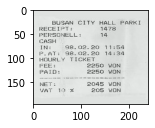

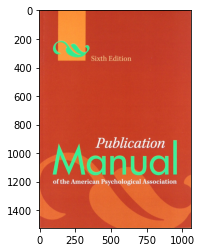

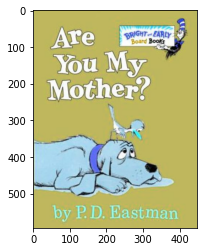

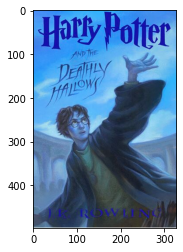

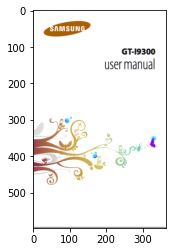

In [4]:
fig = plt.figure(figsize=(20,10))
for idx, path in enumerate(file_path, 1):
    ax = fig.add_subplot(5, 1, idx)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    plt.imshow(img)
    
    plt.show()

#### 1. Keras-ocr

In [5]:
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [6]:
images = [keras_ocr.tools.read(path) for path in file_path]
prediction_groups = [pipeline.recognize({path}) for path in file_path]

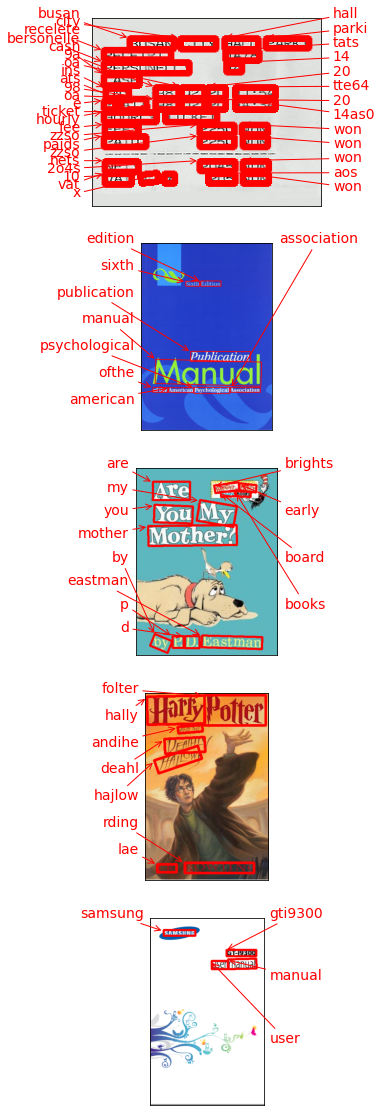

In [7]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0], ax=ax)

#### 2. 테서렉트

In [8]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/image'
    
    
cropped_image_path_list = []
for path in file_path:
    image_path_list = crop_word_regions(path, work_dir)
    cropped_image_path_list.extend(image_path_list)

/aiffel/image/0000.png
/aiffel/image/0001.png
/aiffel/image/0002.png
/aiffel/image/0003.png
/aiffel/image/0004.png
/aiffel/image/0005.png
/aiffel/image/0006.png
/aiffel/image/0007.png
/aiffel/image/0008.png
/aiffel/image/0009.png
/aiffel/image/0010.png
/aiffel/image/0011.png
/aiffel/image/0012.png
/aiffel/image/0013.png
/aiffel/image/0014.png
/aiffel/image/0015.png
/aiffel/image/0016.png
/aiffel/image/0017.png
/aiffel/image/0018.png
/aiffel/image/0019.png
/aiffel/image/0020.png
/aiffel/image/0021.png
/aiffel/image/0022.png
/aiffel/image/0023.png
/aiffel/image/0024.png
/aiffel/image/0000.png
/aiffel/image/0001.png
/aiffel/image/0002.png
/aiffel/image/0003.png
/aiffel/image/0004.png
/aiffel/image/0005.png
/aiffel/image/0006.png
/aiffel/image/0007.png
/aiffel/image/0008.png
/aiffel/image/0000.png
/aiffel/image/0001.png
/aiffel/image/0002.png
/aiffel/image/0003.png
/aiffel/image/0000.png
/aiffel/image/0000.png
/aiffel/image/0001.png
/aiffel/image/0002.png
/aiffel/image/0003.png
/aiffel/ima

In [9]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

exam

GT-19300

LISET

manual


the

American

Psychological

Association

= fr | =

ae. ()e. ory

7

4 iLineL ¥

Ticker |

ee

f= b= be <

wy

WEIN

i"ce | id=

2250

wlLIN

Ner: 2085 VON

he

L7( *,

WhINM

exam

GT-19300

LISET

manual


the

American

Psychological

Association

exam

GT-19300

LISET

manual

exam

exam

GT-19300

LISET

manual


Done


### Step3. 테스트 결과 정리
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

### Step4. 결과 분석과 결론 제시
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

1 번째 이미지
원본 이미지


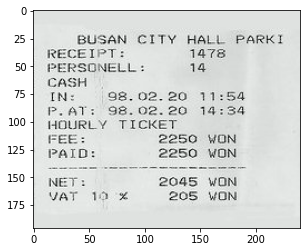

keras 결과 이미지
테서렉트 결과
/aiffel/image_comparison0/0000.png
/aiffel/image_comparison0/0001.png
/aiffel/image_comparison0/0002.png
/aiffel/image_comparison0/0003.png
/aiffel/image_comparison0/0004.png
/aiffel/image_comparison0/0005.png
/aiffel/image_comparison0/0006.png
/aiffel/image_comparison0/0007.png
/aiffel/image_comparison0/0008.png
/aiffel/image_comparison0/0009.png
/aiffel/image_comparison0/0010.png
/aiffel/image_comparison0/0011.png
/aiffel/image_comparison0/0012.png
/aiffel/image_comparison0/0013.png
/aiffel/image_comparison0/0014.png
/aiffel/image_comparison0/0015.png
/aiffel/image_comparison0/0016.png
/aiffel/image_comparison0/0017.png
/aiffel/image_comparison0/0018.png
/aiffel/image_comparison0/0019.png
/aiffel/image_comparison0/0020.png
/aiffel/image_comparison0/0021.png
/aiffel/image_comparison0/0022.png
/aiffel/image_comparison0/0023.png
/aiffel/image_comparison0/0024.png
eLISAN

Poona pn

rival |

rie he |

14 fess

14

pera

968. Of. 20

1

= fr | =

ae. ()e. ory

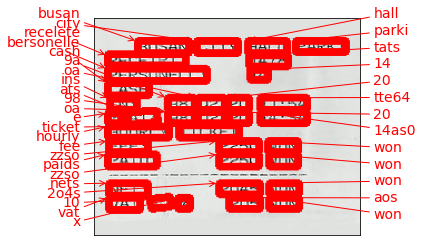

In [62]:
print(1, '번째 이미지')

print('원본 이미지')
img = cv2.imread(file_path[0], cv2.IMREAD_COLOR)
plt.imshow(img)
plt.show()

print('keras 결과 이미지')
keras_ocr.tools.drawAnnotations(image=images[0], predictions=prediction_groups[0][0])

print('테서렉트 결과')
work_dir = os.getenv('HOME')+'/image'+str(0)
cropped_image_path = crop_word_regions(file_path[0], work_dir)
recognize_images(cropped_image_path)

2 번째 이미지
원본 이미지


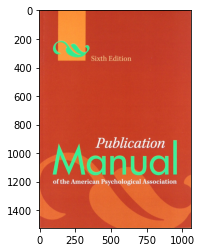

keras 결과 이미지
테서렉트 결과
/aiffel/image_comparison1/0000.png
/aiffel/image_comparison1/0001.png
/aiffel/image_comparison1/0002.png
/aiffel/image_comparison1/0003.png
/aiffel/image_comparison1/0004.png
/aiffel/image_comparison1/0005.png
/aiffel/image_comparison1/0006.png
/aiffel/image_comparison1/0007.png
/aiffel/image_comparison1/0008.png
Sixth

Edition

iy

Wvetavttel

of

the

American

Psychological

Association

Done


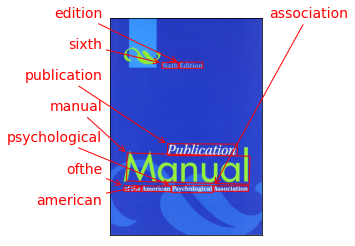

In [63]:
print(2, '번째 이미지')

print('원본 이미지')
img = cv2.imread(file_path[1], cv2.IMREAD_COLOR)
plt.imshow(img)
plt.show()

print('keras 결과 이미지')
keras_ocr.tools.drawAnnotations(image=images[1], predictions=prediction_groups[1][0])

print('테서렉트 결과')
work_dir = os.getenv('HOME')+'/image'+str(1)
cropped_image_path = crop_word_regions(file_path[1], work_dir)
recognize_images(cropped_image_path)

3 번째 이미지
원본 이미지


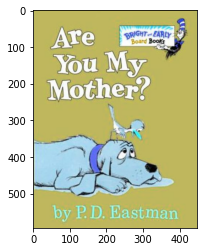

keras 결과 이미지
테서렉트 결과
/aiffel/image_comparison2/0000.png
/aiffel/image_comparison2/0001.png
/aiffel/image_comparison2/0002.png
/aiffel/image_comparison2/0003.png

You

Mother?


Done


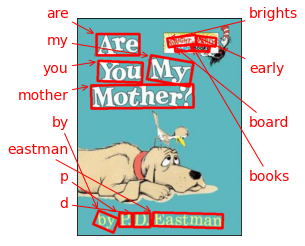

In [64]:
print(3, '번째 이미지')
print('원본 이미지')
img = cv2.imread(file_path[2], cv2.IMREAD_COLOR)
plt.imshow(img)
plt.show()

print('keras 결과 이미지')
keras_ocr.tools.drawAnnotations(image=images[2], predictions=prediction_groups[2][0])

print('테서렉트 결과')
work_dir = os.getenv('HOME')+'/image'+str(2)
cropped_image_path = crop_word_regions(file_path[2], work_dir)
recognize_images(cropped_image_path)

4 번째 이미지
원본 이미지


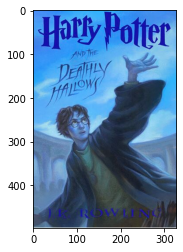

keras 결과 이미지
테서렉트 결과
/aiffel/image_comparison3/0000.png

Done


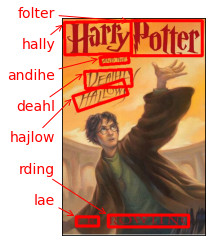

In [65]:
print(4, '번째 이미지')
print('원본 이미지')
img = cv2.imread(file_path[3], cv2.IMREAD_COLOR)
plt.imshow(img)
plt.show()

print('keras 결과 이미지')
keras_ocr.tools.drawAnnotations(image=images[3], predictions=prediction_groups[3][0])

print('테서렉트 결과')
work_dir = os.getenv('HOME')+'/image'+str(3)
cropped_image_path = crop_word_regions(file_path[3], work_dir)
recognize_images(cropped_image_path)

5 번째 이미지
원본 이미지


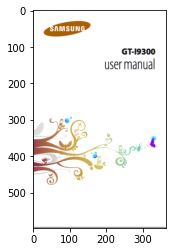

keras 결과 이미지
테서렉트 결과
/aiffel/image4/0000.png
/aiffel/image4/0001.png
/aiffel/image4/0002.png
/aiffel/image4/0003.png
/aiffel/image4/0004.png
exam

GT-19300

LISET

manual


Done


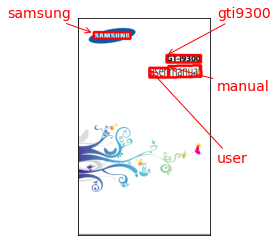

In [66]:
print(5, '번째 이미지')
print('원본 이미지')
img = cv2.imread(file_path[4], cv2.IMREAD_COLOR)
plt.imshow(img)
plt.show()

print('keras 결과 이미지')
keras_ocr.tools.drawAnnotations(image=images[4], predictions=prediction_groups[4][0])

print('테서렉트 결과')
work_dir = os.getenv('HOME')+'/image'+str(4)
cropped_image_path = crop_word_regions(file_path[4], work_dir)
recognize_images(cropped_image_path)

### 기획 하고자 하는 서비스

- 시각 장애인을 위한 듣는책 서비스
    - 읽기 원하는 책을 기게에 넣으면 책을 자동으로 넘기면서 해당 페이지의 내용을 OCR 하여 음성으로 변환해 읽어주는 서비스

## 프로젝트 결과 및 회고
- 이번 프로젝트는 OCR 기술을 활용하여 이미지에 나타난 글자를 판독하는 프로젝트 입니다.
- 크게 두 가지 모델을 활용하여 프로젝트를 진행하였습니다. 첫 번째는 keras ocr, 두 번째는 테서렉트 ocr 입니다.
- 두 가지 모델의 차이점을 분석해보면 우선 keras ocr은 텍스트가 존재하는 곳을 탐지하고 각각의 사각형을 텍스트로 변환하여 태그를 달아주는 형식으로 진행됩니다. keras ocr은 시각적으로 결과를 즉시 확인할 수 있어서 좋았으나 필기체나 특이한 형식의 텍스트에 대해서는 인식은 하지만 원래의 텍스트와 전혀 다른 텍스트를 결과로 출력하는 경우가 많습니다. 반대로 테서렉트 ocr은 텍스트가 존재하는 부분을 새로운 이미지로 저장을 하고 각각의 저장된 이미지를 분석하여 텍스트로 반환하는 형태로 진행됩니다. 또한 테서렉트 ocr은 언어를 지정해주어야 하며 설정하지 않은 언어에 대해서는 낮은 인식률을 보입니다. 
- google ocr에 대해서는 결제과정이 존재해서 혹시하는 마음에 진행을 하지 못하였지만 나중에 기회가 된다면 가장 좋은 성능을 보인다는 google ocr 모델을 실험해 볼 수 있도록 하곘습니다.